# Imports

In [51]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2

import scipy.io as spio

Using TensorFlow backend.


# Functions

In [93]:
# Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def PGNN_train_test(optimizer_name, optimizer_val, drop_rate, iteration, n_layers, n_nodes,
                    tr_size, lake_name, use_YPhy):
        
    # Hyper-parameters of the training process
#     batch_size = int(tr_size/2)
    batch_size = 1000
    num_epochs = 1000
    val_frac = 0.25
    patience_val = 100
    
    # Initializing results filename
    exp_name = "Lake_Pre-train" + optimizer_name + '_drop' + str(drop_rate) + '_nL' + str(n_layers) + '_nN' + str(n_nodes) + '_trsize' + str(tr_size) + '_iter' + str(iteration)
    exp_name = exp_name.replace('.','pt')
    results_dir = '../../results/Lake/'
    model_name = results_dir + exp_name + '.h5' # storing the trained model
    results_name = results_dir + exp_name + '_results.dat' # storing the results of the model
    
    # Loading unsupervised data
    data_dir = '../../data/'
    unsup_filename = lake_name + '_sampled.mat'
    unsup_mat = spio.loadmat(data_dir+unsup_filename, squeeze_me=True,
    variable_names=['Xc_doy1','Xc_doy2'])
    
    uX1 = unsup_mat['Xc_doy1'] # Xc at depth i for every pair of consecutive depth values
    uY1 = uX1[:,-1]
    uX1 = uX1[:,:-1]
#     uX2 = unsup_mat['Xc_doy2'] # Xc at depth i + 1 for every pair of consecutive depth values

    # train and test data
    trainX, trainY = uX1[:tr_size,:], uY1[:tr_size]
    testX, testY = uX1[tr_size:,:], uY1[tr_size:]
    
    # Creating the model
    model = Sequential()
    for layer in np.arange(n_layers):
        if layer == 0:
            model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
        else:
#              model.add(Dense(n_nodes, activation='relu'))
            model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
        model.add(Dropout(rate=drop_rate))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer_val,
                  metrics=[root_mean_squared_error])
    
    
#     with tf.Session() as sess:
#         init = tf.global_variables_initializer()
#         sess.run(init)
#         print(predictions[:,0].eval())
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val,verbose=1)
    
    print('Running...' + optimizer_name)
    history = model.fit(trainX, trainY,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        verbose=1,
                        validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])
#     print(testX)
    test_score = model.evaluate(testX, testY, verbose=0)
    print(test_score[0], test_score[1])
    print('iter: ' + str(iteration) + 
          ' nL: ' + str(n_layers) + ' nN: ' + str(n_nodes) + 
          ' trsize: ' + str(tr_size) + 
          ' TestRMSE: ' + str(test_score[1]))
    
#     predictions = model.predict(uX1) # model output at depth i
#     print(np.sort(predictions[:,0], axis=0))
    
    model.save(model_name)
    
    # save results
    dictnry = {'train_rmse':history.history['root_mean_squared_error'], 
                                'val_rmse':history.history['val_root_mean_squared_error'],
                                'test_rmse':test_score[1]}

    return dictnry, results_name

In [94]:
# Main Function
if __name__ == '__main__':
    
    # List of optimizers to choose from    
    optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
    optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]
    
    # selecting the optimizer
    optimizer_num = 2
    optimizer_name = optimizer_names[optimizer_num]
    optimizer_val = optimizer_vals[optimizer_num]
    
    # Selecting Other Hyper-parameters
    drop_rate = 0.1 # Fraction of nodes to be dropped out
    n_layers = 2 # Number of hidden layers
    n_nodes = 15 # Number of nodes per hidden layer

    # Iterating over different training fractions and splitting indices for train-test splits
#     trsize_range = [1500,20,15,10,5]
#     trsize_range = [24]
#     trsize_range = [1303]
    trsize_range = [300000]
    
    iter_range = np.arange(1) # range of iteration numbers for random initialization of NN parameters
    tr_size = trsize_range[0]
    
    #List of lakes to choose from
    lake = ['mendota' , 'mille_lacs']
    lake_num = 0  # 0 : mendota , 1 : mille_lacs
    lake_name = lake[lake_num]
    
    use_YPhy  = 0
    
    # iterating through all possible params
    for iteration in iter_range:
        results, result_file = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                        iteration, n_layers, n_nodes, tr_size, lake_name, use_YPhy )

Running...Adam
Train on 225000 samples, validate on 75000 samples
Epoch 1/1000
225000/225000 [==============================] - 1s 3us/step - loss: 0.7133 - root_mean_squared_error: 0.5819 - val_loss: 0.2622 - val_root_mean_squared_error: 0.3626
Epoch 2/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.3097 - root_mean_squared_error: 0.3848 - val_loss: 0.2039 - val_root_mean_squared_error: 0.3145
Epoch 3/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.2539 - root_mean_squared_error: 0.3429 - val_loss: 0.1796 - val_root_mean_squared_error: 0.2908
Epoch 4/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.2266 - root_mean_squared_error: 0.3233 - val_loss: 0.1676 - val_root_mean_squared_error: 0.2820
Epoch 5/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.2074 - root_mean_squared_error: 0.3103 - val_loss: 0.1538 - val_root_mean_squared_error: 0.2701
Epoch 6/1000
225000/225000 [======

225000/225000 [==============================] - 0s 2us/step - loss: 0.0851 - root_mean_squared_error: 0.2084 - val_loss: 0.0856 - val_root_mean_squared_error: 0.2204
Epoch 46/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0855 - root_mean_squared_error: 0.2087 - val_loss: 0.0876 - val_root_mean_squared_error: 0.2245
Epoch 47/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0850 - root_mean_squared_error: 0.2081 - val_loss: 0.0852 - val_root_mean_squared_error: 0.2229
Epoch 48/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0843 - root_mean_squared_error: 0.2078 - val_loss: 0.0836 - val_root_mean_squared_error: 0.2167
Epoch 49/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0843 - root_mean_squared_error: 0.2079 - val_loss: 0.0829 - val_root_mean_squared_error: 0.2154
Epoch 50/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0844 - root_mean_squared

225000/225000 [==============================] - 0s 2us/step - loss: 0.0797 - root_mean_squared_error: 0.2053 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2090
Epoch 91/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0800 - root_mean_squared_error: 0.2052 - val_loss: 0.0787 - val_root_mean_squared_error: 0.2123
Epoch 92/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0797 - root_mean_squared_error: 0.2052 - val_loss: 0.0784 - val_root_mean_squared_error: 0.2162
Epoch 93/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0799 - root_mean_squared_error: 0.2056 - val_loss: 0.0787 - val_root_mean_squared_error: 0.2110
Epoch 94/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0799 - root_mean_squared_error: 0.2054 - val_loss: 0.0784 - val_root_mean_squared_error: 0.2125
Epoch 95/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0792 - root_mean_squared

225000/225000 [==============================] - 0s 2us/step - loss: 0.0785 - root_mean_squared_error: 0.2047 - val_loss: 0.0724 - val_root_mean_squared_error: 0.2002
Epoch 136/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0778 - root_mean_squared_error: 0.2040 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2004
Epoch 137/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0780 - root_mean_squared_error: 0.2042 - val_loss: 0.0789 - val_root_mean_squared_error: 0.2139
Epoch 138/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0780 - root_mean_squared_error: 0.2043 - val_loss: 0.0742 - val_root_mean_squared_error: 0.2033
Epoch 139/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0777 - root_mean_squared_error: 0.2037 - val_loss: 0.0788 - val_root_mean_squared_error: 0.2090
Epoch 140/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0777 - root_mean_sq

225000/225000 [==============================] - 0s 2us/step - loss: 0.0782 - root_mean_squared_error: 0.2045 - val_loss: 0.0819 - val_root_mean_squared_error: 0.2182
Epoch 181/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0776 - root_mean_squared_error: 0.2041 - val_loss: 0.0711 - val_root_mean_squared_error: 0.1999
Epoch 182/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0772 - root_mean_squared_error: 0.2037 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2088
Epoch 183/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0778 - root_mean_squared_error: 0.2047 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2097
Epoch 184/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0774 - root_mean_squared_error: 0.2039 - val_loss: 0.0712 - val_root_mean_squared_error: 0.2016
Epoch 185/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0773 - root_mean_sq

225000/225000 [==============================] - 0s 2us/step - loss: 0.0772 - root_mean_squared_error: 0.2044 - val_loss: 0.0742 - val_root_mean_squared_error: 0.2029
Epoch 225/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0769 - root_mean_squared_error: 0.2038 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2071
Epoch 226/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0766 - root_mean_squared_error: 0.2037 - val_loss: 0.0700 - val_root_mean_squared_error: 0.1975
Epoch 227/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0769 - root_mean_squared_error: 0.2040 - val_loss: 0.0746 - val_root_mean_squared_error: 0.2071
Epoch 228/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0773 - root_mean_squared_error: 0.2041 - val_loss: 0.0695 - val_root_mean_squared_error: 0.1948
Epoch 229/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0769 - root_mean_sq

225000/225000 [==============================] - 0s 2us/step - loss: 0.0766 - root_mean_squared_error: 0.2039 - val_loss: 0.0730 - val_root_mean_squared_error: 0.2038
Epoch 270/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0767 - root_mean_squared_error: 0.2038 - val_loss: 0.0723 - val_root_mean_squared_error: 0.2034
Epoch 271/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0763 - root_mean_squared_error: 0.2037 - val_loss: 0.0776 - val_root_mean_squared_error: 0.2110
Epoch 272/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0766 - root_mean_squared_error: 0.2035 - val_loss: 0.0728 - val_root_mean_squared_error: 0.2107
Epoch 273/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2034 - val_loss: 0.0758 - val_root_mean_squared_error: 0.2063
Epoch 274/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0762 - root_mean_sq

Epoch 314/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0766 - root_mean_squared_error: 0.2041 - val_loss: 0.0732 - val_root_mean_squared_error: 0.2026
Epoch 315/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0765 - root_mean_squared_error: 0.2039 - val_loss: 0.0675 - val_root_mean_squared_error: 0.1932
Epoch 316/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0764 - root_mean_squared_error: 0.2039 - val_loss: 0.0762 - val_root_mean_squared_error: 0.2078
Epoch 317/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0762 - root_mean_squared_error: 0.2036 - val_loss: 0.0827 - val_root_mean_squared_error: 0.2348
Epoch 318/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0762 - root_mean_squared_error: 0.2038 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2075
Epoch 319/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0764

Epoch 359/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2039 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2101
Epoch 360/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2038 - val_loss: 0.0730 - val_root_mean_squared_error: 0.2064
Epoch 361/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0764 - root_mean_squared_error: 0.2042 - val_loss: 0.0822 - val_root_mean_squared_error: 0.2224
Epoch 362/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0769 - root_mean_squared_error: 0.2042 - val_loss: 0.0761 - val_root_mean_squared_error: 0.2119
Epoch 363/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0764 - root_mean_squared_error: 0.2043 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2020
Epoch 364/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0763

Epoch 404/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0769 - root_mean_squared_error: 0.2044 - val_loss: 0.0745 - val_root_mean_squared_error: 0.2124
Epoch 405/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0766 - root_mean_squared_error: 0.2038 - val_loss: 0.0723 - val_root_mean_squared_error: 0.2076
Epoch 406/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0762 - root_mean_squared_error: 0.2035 - val_loss: 0.0717 - val_root_mean_squared_error: 0.1983
Epoch 407/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2032 - val_loss: 0.0758 - val_root_mean_squared_error: 0.2120
Epoch 408/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0764 - root_mean_squared_error: 0.2038 - val_loss: 0.0719 - val_root_mean_squared_error: 0.1999
Epoch 409/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0765

225000/225000 [==============================] - 0s 2us/step - loss: 0.0762 - root_mean_squared_error: 0.2039 - val_loss: 0.0761 - val_root_mean_squared_error: 0.2175
Epoch 450/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0760 - root_mean_squared_error: 0.2037 - val_loss: 0.0670 - val_root_mean_squared_error: 0.1934
Epoch 451/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0763 - root_mean_squared_error: 0.2039 - val_loss: 0.0765 - val_root_mean_squared_error: 0.2094
Epoch 452/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2033 - val_loss: 0.0751 - val_root_mean_squared_error: 0.2148
Epoch 453/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0763 - root_mean_squared_error: 0.2036 - val_loss: 0.0755 - val_root_mean_squared_error: 0.2084
Epoch 454/1000
225000/225000 [==============================] - 1s 2us/step - loss: 0.0762 - root_mean_sq

225000/225000 [==============================] - 0s 2us/step - loss: 0.0754 - root_mean_squared_error: 0.2030 - val_loss: 0.0773 - val_root_mean_squared_error: 0.2153
Epoch 495/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0762 - root_mean_squared_error: 0.2039 - val_loss: 0.0718 - val_root_mean_squared_error: 0.2048
Epoch 496/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0765 - root_mean_squared_error: 0.2041 - val_loss: 0.0720 - val_root_mean_squared_error: 0.1957
Epoch 497/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0765 - root_mean_squared_error: 0.2042 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2108
Epoch 498/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2033 - val_loss: 0.0783 - val_root_mean_squared_error: 0.2183
Epoch 499/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0765 - root_mean_sq

225000/225000 [==============================] - 0s 2us/step - loss: 0.0756 - root_mean_squared_error: 0.2028 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2144
Epoch 539/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0760 - root_mean_squared_error: 0.2030 - val_loss: 0.0748 - val_root_mean_squared_error: 0.2105
Epoch 540/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0759 - root_mean_squared_error: 0.2030 - val_loss: 0.0711 - val_root_mean_squared_error: 0.2025
Epoch 541/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0753 - root_mean_squared_error: 0.2024 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2103
Epoch 542/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2034 - val_loss: 0.0711 - val_root_mean_squared_error: 0.2016
Epoch 543/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0757 - root_mean_sq

225000/225000 [==============================] - 0s 2us/step - loss: 0.0751 - root_mean_squared_error: 0.2023 - val_loss: 0.0695 - val_root_mean_squared_error: 0.2005
Epoch 583/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0757 - root_mean_squared_error: 0.2029 - val_loss: 0.0721 - val_root_mean_squared_error: 0.2031
Epoch 584/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0756 - root_mean_squared_error: 0.2029 - val_loss: 0.0683 - val_root_mean_squared_error: 0.1938
Epoch 585/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0762 - root_mean_squared_error: 0.2037 - val_loss: 0.0676 - val_root_mean_squared_error: 0.1901
Epoch 586/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0755 - root_mean_squared_error: 0.2023 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2017
Epoch 587/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0760 - root_mean_sq

Epoch 627/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0754 - root_mean_squared_error: 0.2022 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2047
Epoch 628/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2032 - val_loss: 0.0723 - val_root_mean_squared_error: 0.2087
Epoch 629/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0758 - root_mean_squared_error: 0.2030 - val_loss: 0.0704 - val_root_mean_squared_error: 0.2023
Epoch 630/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0754 - root_mean_squared_error: 0.2023 - val_loss: 0.0791 - val_root_mean_squared_error: 0.2183
Epoch 631/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0761 - root_mean_squared_error: 0.2032 - val_loss: 0.0687 - val_root_mean_squared_error: 0.1967
Epoch 632/1000
225000/225000 [==============================] - 0s 2us/step - loss: 0.0757

In [95]:
# # Loading unsupervised data
# data_dir = '../../data/'
# unsup_filename = 'mendota' + '_sampled.mat'
# unsup_mat = spio.loadmat(data_dir+unsup_filename, squeeze_me=True,
# variable_names=['Xc_doy1','Xc_doy2'])

# uX1 = unsup_mat['Xc_doy1'] # Xc at depth i for every pair of consecutive depth values
# uY1 = uX1[:,-1]
# uX1 = uX1[:,:-1]

# pd.DataFrame(uX1)[4].unique().shape

# pd.DataFrame(uX1).iloc[:150,:]

In [96]:
# model.load(model_name)
# prediction = model.predict(np.array(tk.texts_to_sequences(text)))
# print(prediction)

In [97]:
dict_keys = []

# get key and value 
print ("Dict keys are: ") 
for key, value in results.items(): 
    dict_keys.append(key)

print(dict_keys)
train_rmse = results[dict_keys[0]]
val_rmse = results[dict_keys[1]]
test_rmse = results[dict_keys[2]]
print("Test RMSE: ",test_rmse)

Dict keys are: 
['train_rmse', 'val_rmse', 'test_rmse']
Test RMSE:  0.20168207585811615


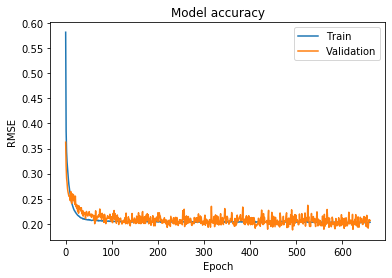

In [98]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(train_rmse)
plt.plot(val_rmse)
plt.title('Model accuracy')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()